In [27]:
import utils
import functools
import operator
from fitness import fit
from dataset import get_data, get_wdc_data
from keras.optimizers import Adam
from sklearn.metrics import classification_report

# Execution

In [39]:
TRAIN_PATH = './dataset/computers/train/computers__train_medium.json'
VALID_PATH = './dataset/computers/valid/computers_splitted_valid_medium.json'
TEST_PATH = './dataset/computers/test/computers_gs.json'
PRETRAINED_EMBEDDING_PATH = './dataset/embeddings/w2v/w2v_title_300Epochs_1MinCount_9ContextWindow_150d.txt'
NUM_WORDS = None
MAX_LEN = 20
BATCH_SIZE = 32
EMBEDDING_DIM = 150
EPOCHS = 20
EXP_DIR = './experiments'
WDC = True

# Set parameters with those computed by pyGPGO

In [40]:
import pickle
with open('./automl_experiments/exp' + str(EMBEDDING_DIM) + 'embedding_w2v.pickle', 'rb') as f:
    params = pickle.load(f)
max_f1 = 0
for param in params:
    if param[1] > max_f1:
        best_params = param[0]
        max_f1 = param[1]
print(best_params)

{'lr': 1e-05, 'rnn_units': 150, 'convs_filter_banks': 32, 'convs_kernel_size': 3, 'pool_size': 2, 'denses_depth': 3}


In [35]:
LR = best_params['lr']
RNN_UNITS = best_params['rnn_units']
SIMILARITY_FUNC = 'dot_similarity' if best_params['similarity_type'] == 0 else 'cosine_similarity'
CONVS_FILTER_BANKS = best_params['convs_filter_banks']
CONVS_KERNEL_SIZE = best_params['convs_kernel_size']
POOL_SIZE = best_params['pool_size']
DENSES_DEPTH = best_params['denses_depth']

if __name__ == "__main__":
    print("* LOADING DATA")
    if not WDC:
        train_gen, val_gen, word_index, class_weights = get_data(
            TRAIN_PATH,
            word_index_path=None,
            num_words=NUM_WORDS,
            max_len=MAX_LEN,
            batch_size=BATCH_SIZE,
            preprocess_data=True,
            preprocess_method="nltk",
            train_test_split=0.8,
        )
    else:
        train_gen, val_gen, test_gen, class_weights = get_wdc_data(
            TRAIN_PATH,
            VALID_PATH,
            TEST_PATH,
            word_index_path="dataset/title_word_index.json",
            num_words=NUM_WORDS,
            max_len=MAX_LEN,
            batch_size=BATCH_SIZE,
            preprocess_data=True,
            preprocess_method="nltk",
        )
        word_index = json.loads(open("dataset/title_word_index.json").read())

    NUM_WORDS = len(word_index) if NUM_WORDS is None else NUM_WORDS
    print("* NUM WORDS: ", NUM_WORDS)
    print("* CLASS WEIGHTS:", class_weights)

    embedding_matrix = None
    if PRETRAINED_EMBEDDING_PATH is not None:
        embedding_matrix = get_pretrained_embedding(
            PRETRAINED_EMBEDDING_PATH, NUM_WORDS + 1, EMBEDDING_DIM, word_index
        )
    matrix_similarity_function = getattr(utils, SIMILARITY_FUNC)
    model, results = fit(
        train_gen,
        val_gen,
        NUM_WORDS,
        EMBEDDING_DIM,
        MAX_LEN,
        matrix_similarity_function,
        EXP_DIR,
        None,
        denses_depth=DENSES_DEPTH,
        activation="sigmoid",
        embedding_matrix=embedding_matrix,
        embedding_trainable=False,
        embedding_dropout=0.3,
        rnn_type="LSTM",
        rnn_units=RNN_UNITS,
        convs_filter_banks=CONVS_FILTER_BANKS,
        convs_kernel_size=CONVS_KERNEL_SIZE,
        pool_size=POOL_SIZE,
        mlp_dropout=0.3,
        epochs=EPOCHS,
        verbosity=1,
        callbacks=False,
        class_weights=class_weights,
        optimizer=Adam(learning_rate=LR),
    )

* LOADING DATA
* PREPROCESS DATA
* DONE
* FOUND 4362 unique vocabs
* PREPROCESS DATA
* DONE
* FOUND 3444 unique vocabs
* PREPROCESS DATA
* DONE
* FOUND 2791 unique vocabs
* NUM WORDS:  4764
* CLASS WEIGHTS: [0.63919052 2.29609929]
* LOADING EMBEDDINGS MATRIX
* FOUND 4764 WORD VECTORS
* FOUND 4764 vector representations out of 4765 words
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 100)   

/home/belerico/.local/share/virtualenvs/aml-project-EQl709OG/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
y_true = [v[1] for v in test_gen]
y_true = functools.reduce(operator.iconcat, y_true, [])
predictions = model.predict(test_gen) > 0.5
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84       794
           1       0.00      0.00      0.00       294

    accuracy                           0.73      1088
   macro avg       0.36      0.50      0.42      1088
weighted avg       0.53      0.73      0.62      1088



# Visualization

In [0]:
from dataset import Dataset

Using TensorFlow backend.


In [0]:
words_embeddings = {w:embed[idx] for w, idx in word_index.items()
                      if idx < config['NUM_WORDS']}

print(words_embeddings['computer']) 

[ 0.01335766 -0.09319739  0.14987466  0.04207904  0.15228829 -0.09939939
 -0.11095019 -0.05169841  0.11709139  0.01284923]


In [0]:
import pandas as pd
from utils import parse_content_line
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [0]:
 contents = np.concatenate([parse_content_line(x) for x in open(config['DATA_PATH'], "r").readlines()],
                                  axis=0)

In [0]:
dfItem = pd.DataFrame.from_records(contents, columns=['title1', 'title2', 'match'])

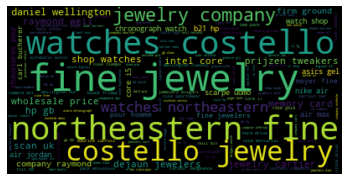

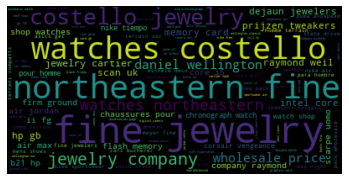

In [0]:
dfItemtext = dfItem.title1[0]
text1 = " ".join(review for review in dfItem.title1)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

text = " ".join(review for review in dfItem.title2)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()